In [1]:
import wave
import sounddevice as sd
import numpy as np
import subprocess
import time
import os
from visqol import visqol_lib_py
from visqol.pb2 import visqol_config_pb2
from visqol.pb2 import similarity_result_pb2
import shutup
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import random
import scipy as sc
from scipy.io.wavfile import write
from IPython.display import Audio, display


shutup.please()

In [3]:

# Set the parameters for recording
duration = 10  # recording duration in seconds
sample_rate = 48000  # sampling frequency in Hz
channels = 1  # 1 for mono, 2 for stereo

# Record audio
print("3")
time.sleep(1)
print("2")
time.sleep(1)
print("1")
time.sleep(1)
print("Recording...")
audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=channels)
sd.wait()
print("Done!")


3
2
1
Recording...
Done!


In [4]:
# Save the clean audio for reference
reference_signal = audio_data.flatten()

# Different background noises
car_noise = "../soundFiles/car/50910__rutgermuller__in-car-driving.wav"
nature_noise = "../soundFiles/nature/423711__mikevpme__jungle-tropical-birds-and-insects.wav"
traffic_noise = "../soundFiles/traffic/462734__rucisko__busy-city-07.wav"
beach_noise = "../soundFiles/nature/683527__eqavox__breezy-beach.wav"
jazz_club_noise = "../soundFiles/people/397935__martineerok__crowd-in-front-of-jazzclub.wav"
market_noise = "../soundFiles/traffic/262231__ramston__lebanese-arab-market-busy-people-traffic-music.wav"

# Add noise to the reference signal
noise_src = car_noise

# Desired SNR
SNR = 15

# Read the noise file
noise_, noise_fs = sf.read(noise_src, dtype=np.int16)

# Resample from noisefile's sampling frequency to 48kHz to make files compatible with rnnoise
if (noise_fs != sample_rate):
    noise_t = len(noise_) / noise_fs
    noise = sc.signal.resample(noise_, int(noise_t)*sample_rate).astype(np.int16)
else: noise = noise_

# Turn the audio to mono

#noise = noise_[:, 0]

# Equalize lengths                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
start = random.randint(0, len(noise) - len(reference_signal))
noise_eqlen = noise[start : start + len(reference_signal)]

# Scale the reference signal to correct range before converting to int16 type
# Casting them straight to int16 would make the floating point numbers 0.
clean = (reference_signal * 32767).astype(np.int16)

# Save the files as wav to tmp folder
output_file = wave.Wave_write("./tmp/clean.wav")
output_file.setparams((channels, 2, sample_rate, 0, 'NONE', 'NONE')) #nchannels, sampwidth, framerate, nframes, comptype, compname
output_file.writeframes(clean.tobytes() )
output_file.close()

output_file = wave.Wave_write("./tmp/noise.wav")
output_file.setparams((channels, 2, sample_rate, 0, 'NONE', 'NONE')) #nchannels, sampwidth, framerate, nframes, comptype, compname
output_file.writeframes(noise.tobytes() )
output_file.close()

# Add noise to the recorded audio
pyscript = "./audio-SNR/create_mixed_audio_file.py"
fclean = "./tmp/clean.wav"
fnoise = "./tmp/noise.wav"
snr = f"{SNR}"
output = "./Audio/noisy_audio.wav"

# The below python script adds noise to the clean signal and saves it in "noisy.pcm" and "noisy_audio.wav"
subprocess.run(["python"] + 
               [pyscript] + 
               ["--clean_file", fclean] + 
               ["--noise_file", fnoise] + 
               ["--snr", snr] + 
               ["--output_mixed_file", output])

def play_audio(file_path):
    audio = Audio(file_path)
    display(audio)

noisy_audio_path = 'Audio/noisy_audio.wav'
print("Play the audio with added noise")
play_audio(noisy_audio_path)

Play the audio with added noise


In [5]:
# Read the raw PCM data
with open('./Audio/noisy.pcm', 'rb') as noisy_pcm:
    noisy_pcm_data = noisy_pcm.read()
# Convert into np array and write to wav
noisy_np = (np.frombuffer(noisy_pcm_data, dtype="int16")).astype(np.int16)

# Specify the path to the compiled C program
c_program_path = "../rnnoise/examples/rnnoise_demo"

# Specify command-line arguments if needed
command_line_arguments = ["./Audio/noisy.pcm", "./Audio/denoised.pcm"]

# Execute the compiled C program with command-line arguments
subprocess.run([c_program_path] + command_line_arguments)



CompletedProcess(args=['../rnnoise/examples/rnnoise_demo', './Audio/noisy.pcm', './Audio/denoised.pcm'], returncode=0)

In [6]:
# Specify the WAV file parameters
sample_width = 2  # 16-bit PCM
sample_rate = sample_rate 
channels = 1  # 1 for mono, 2 for stereo

# Read the raw PCM data
with open('./Audio/denoised.pcm', 'rb') as denoised_pcm:
    pcm_data = denoised_pcm.read()
# Convert into np array and write to wav
denoised_np = np.frombuffer(pcm_data, dtype="int16").astype(np.int16)


denoised_np_cut = denoised_np[sample_rate:len(denoised_np)-sample_rate]
output_file = wave.Wave_write("./Audio/denoised.wav")
output_file.setparams((channels, 2, sample_rate, 0, 'NONE', 'NONE')) #nchannels, sampwidth, framerate, nframes, comptype, compname
output_file.writeframes(denoised_np_cut.tobytes() )
output_file.close()

denoised_audio_path = 'Audio/denoised.wav'

print("Play the denoised audio:")
play_audio(denoised_audio_path)



Play the denoised audio:


In [7]:

# Perform visqol analysis
config = visqol_config_pb2.VisqolConfig()

# Path to the reference and degraded WAV files
degraded_file = "Audio/denoised.wav"

# Read audio files into numpy arrays
degraded, _ = sf.read(degraded_file)
reference = np.float64(reference_signal[sample_rate:len(reference_signal)-sample_rate])

# Equalize reference length with noisy
#reference_signal = np.float64(reference_signal[sample_rate:len(reference_signal)-2*sample_rate])


mode = "audio"
if mode == "audio":
    config.audio.sample_rate = 48000
    config.options.use_speech_scoring = False
    svr_model_path = "libsvm_nu_svr_model.txt"
elif mode == "speech":
    config.audio.sample_rate = 16000
    config.options.use_speech_scoring = True
    svr_model_path = "lattice_tcditugenmeetpackhref_ls2_nl60_lr12_bs2048_learn.005_ep2400_train1_7_raw.tflite"
else:
    raise ValueError(f"Unrecognized mode: {mode}")

config.options.svr_model_path = os.path.join(
    os.path.dirname(visqol_lib_py.__file__), "model", svr_model_path)

api = visqol_lib_py.VisqolApi()

api.Create(config)

similarity_result = api.Measure(reference, degraded)

print(f"The visqol analysis score: {similarity_result.moslqo}   (1 is worst, 5 is best)")


The visqol analysis score: 4.17086157871142   (1 is worst, 5 is best)


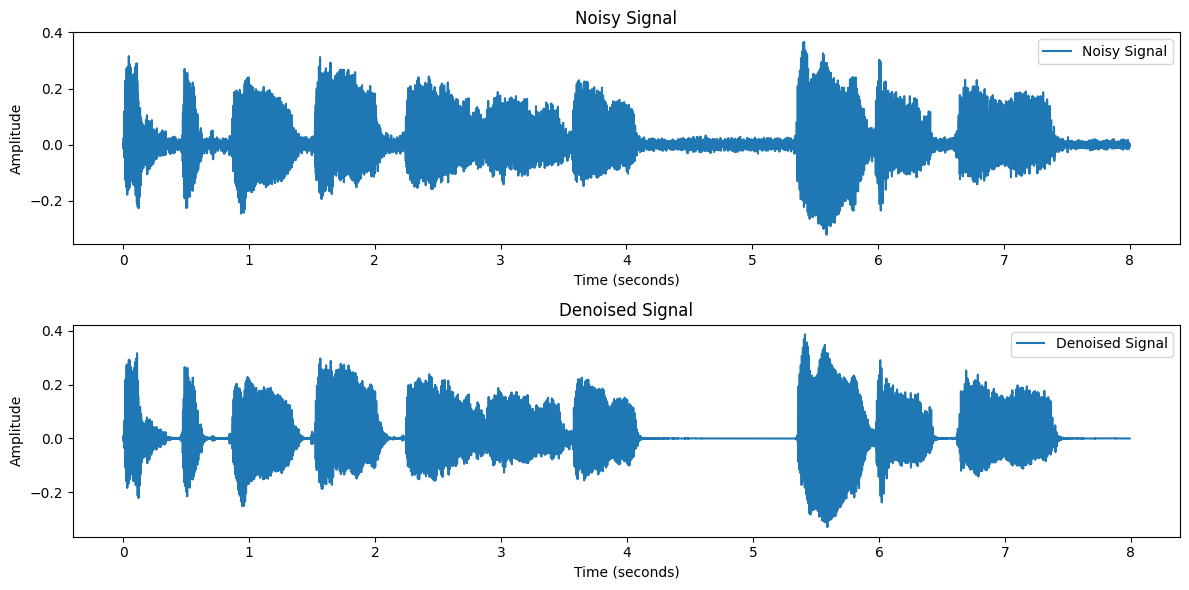

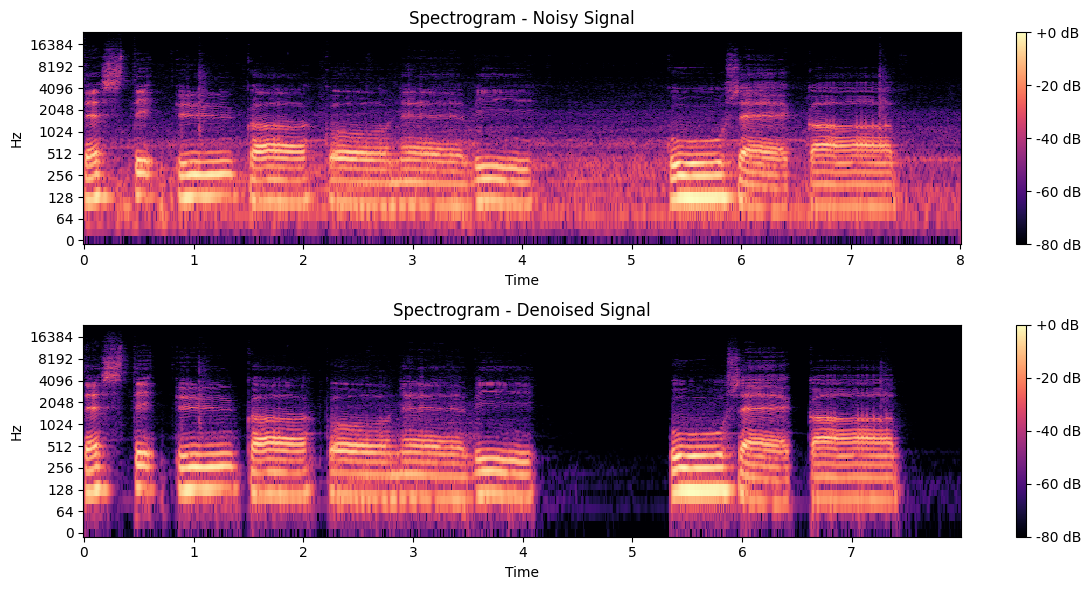

In [8]:
noisy_signal_, _ = sf.read("./Audio/noisy_audio.wav")
noisy_signal = np.float64(noisy_signal_[sample_rate:len(noisy_signal_)-sample_rate])

# Create time vectors for plotting
time_degraded = np.arange(0, len(degraded)) / sample_rate
time_noisy = np.arange(0, len(noisy_signal)) / sample_rate

# Plot the signals
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time_noisy, noisy_signal, label='Noisy Signal')
plt.title('Noisy Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_degraded, degraded, label='Denoised Signal')
plt.title('Denoised Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

# Compute spectrograms using librosa
degraded_spec = librosa.amplitude_to_db(np.abs(librosa.stft(degraded)), ref=np.max)
noisy_spec = librosa.amplitude_to_db(np.abs(librosa.stft(noisy_signal)), ref=np.max)

# Plot the spectrograms
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 2)
librosa.display.specshow(degraded_spec, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram - Denoised Signal')

plt.subplot(2, 1, 1)
librosa.display.specshow(noisy_spec, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram - Noisy Signal')

plt.tight_layout()
plt.show()